In [99]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt

In [ ]:
# 1111 1111 --> 255

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

In [5]:
a = tf.constant("hello ")
b = tf.constant([[3,4],[1,2]])
c = tf.constant([[1,2],[5,5]])

In [7]:
bc = b + c
print(bc)

tf.Tensor(
[[4 6]
 [6 7]], shape=(2, 2), dtype=int32)


In [26]:
bc.numpy()

array([[10, 11],
       [ 8,  9]], dtype=int32)

In [12]:
d_numpy = np.random.random((2,2))
d_numpy

array([[0.79172504, 0.52889492],
       [0.56804456, 0.92559664]])

In [18]:
help(tf.random.uniform)

Help on function random_uniform in module tensorflow.python.ops.random_ops:

random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)
    Outputs random values from a uniform distribution.
    
    The generated values follow a uniform distribution in the range
    `[minval, maxval)`. The lower bound `minval` is included in the range, while
    the upper bound `maxval` is excluded.
    
    For floats, the default range is `[0, 1)`.  For ints, at least `maxval` must
    be specified explicitly.
    
    In the integer case, the random integers are slightly biased unless
    `maxval - minval` is an exact power of two.  The bias is small for values of
    `maxval - minval` significantly smaller than the range of the output (either
    `2**32` or `2**64`).
    
    Examples:
    
    >>> tf.random.uniform(shape=[2])
    <tf.Tensor: shape=(2,), dtype=float32, numpy=array([..., ...], dtype=float32)>
    >>> tf.random.uniform(shape=[], minval=-1., maxval=0.)
    <

In [25]:
d_tf = tf.random.uniform((2,2), minval=-1, maxval=2, dtype=tf.int32)
d_tf

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 1, -1],
       [ 0, -1]], dtype=int32)>

In [30]:
round(0.52), int(0.52)

(1, 0)

In [27]:
d = tf.random.uniform((2,2), dtype=tf.float32)
print(d)
d = tf.cast(d, dtype=tf.int32)
d

tf.Tensor(
[[0.09492064 0.78148305]
 [0.82439435 0.5376601 ]], shape=(2, 2), dtype=float32)


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 0],
       [0, 0]], dtype=int32)>

In [32]:
bd = tf.concat((b, d), axis=1)
bd

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[3, 4, 0, 0],
       [1, 2, 0, 0]], dtype=int32)>

In [33]:
tf.transpose(bd)

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[3, 1],
       [4, 2],
       [0, 0],
       [0, 0]], dtype=int32)>

In [37]:
df_test = pd.read_csv('./data/test.csv')
df_train = pd.read_csv('./data/train.csv')
df_submission = pd.read_csv('./data/gender_submission.csv')

In [41]:
def transform(df,option):
    assert option in ["test","train"] , "Option must be test or train"
    df = df.set_index('PassengerId')
    cond = df.Fare.isnull()
    sub_value = df.Fare.mean()
    df.Fare = np.where(cond, sub_value, df.Fare)
    ticket_p = df.groupby('Ticket', as_index=False).agg({'Name': 'count'}).rename(columns={'Name':'t_count'}).sort_values('t_count', ascending=False)
    d = dict()
    for i, row in ticket_p.iterrows():
        d[row.Ticket] = row.t_count
    df_merge = df.copy()
    df_merge['t_count'] = df_merge.Ticket.apply(lambda x: d[x])
    df_merge['Fare_per_person'] = df_merge.Fare/df_merge.t_count
    cond = df_merge.Age.isnull()
    sub_value = df_merge.Age.mean()
    df_merge.Age = np.where(cond, sub_value, df_merge.Age)
    cond = (df_merge.Sex == 'female')
    sub_value = 1
    df_merge.Sex = np.where(cond, sub_value, 0)
    cond = df_merge.Embarked.isnull()
    sub_value = 'S'
    df_merge.Embarked = np.where(cond, 'S', df_merge.Embarked)
    df_merge = df_merge.drop(['Name', 'Ticket', 'Cabin'], axis=1)
    df_merge.isnull().sum()
    ohe = OneHotEncoder()
    X_cat = ohe.fit_transform(df_merge.Embarked.values.reshape(-1,1)).toarray()
    if option=="train":
        X_short = df_merge.drop(['Survived','Embarked'], axis=1).values
    else:
        X_short = df_merge.drop(['Embarked'], axis=1).values
    X = np.hstack([X_cat, X_short])
    return X

In [42]:
X_train_val = transform(df_train, "train")
X_test = transform(df_test,"test")
y_train_val = df_train.Survived

In [46]:
X_train_val.shape, y_train_val.shape

((891, 11), (891,))

In [85]:
model = Sequential() # empty placeholder
model.add(Dense(6, input_dim=X_train_val.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0)))
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 6)                 72        
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 35        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 6         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.fit(X_train_val, y_train_val, epochs=20)

Train on 891 samples
Epoch 1/20
891/891 [==============================] - 0s 501us/sample - loss: 2.5334 - accuracy: 0.3165
Epoch 2/20
891/891 [==============================] - 0s 53us/sample - loss: 1.8943 - accuracy: 0.3266
Epoch 3/20
891/891 [==============================] - 0s 67us/sample - loss: 1.4880 - accuracy: 0.3378
Epoch 4/20
891/891 [==============================] - 0s 60us/sample - loss: 1.2324 - accuracy: 0.3367
Epoch 5/20
891/891 [==============================] - 0s 56us/sample - loss: 1.0661 - accuracy: 0.3367
Epoch 6/20
891/891 [==============================] - 0s 56us/sample - loss: 0.9519 - accuracy: 0.3389
Epoch 7/20
891/891 [==============================] - 0s 60us/sample - loss: 0.8724 - accuracy: 0.3502
Epoch 8/20
891/891 [==============================] - 0s 57us/sample - loss: 0.8237 - accuracy: 0.3636
Epoch 9/20
891/891 [==============================] - 0s 53us/sample - loss: 0.7885 - accuracy: 0.3771
Epoch 10/20
891/891 [==============================

In [96]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [97]:
X_train.shape

(60000, 28, 28)

In [104]:
y_train_idx = (y_train == 0) | (y_train == 1)

In [106]:
X_train_bin = X_train[y_train_idx]
y_train_bin = y_train[y_train_idx]

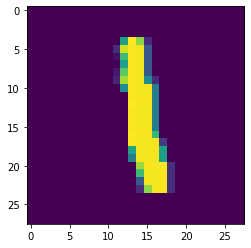

In [109]:
#HW:

# To build a neural network and train it with our reduced dataset X_train_bin/y_train_bin
# hint:
# Flatten layer
# tf.keras.layers.Flatten(input_shape=(28, 28)) in front of your first hidden layer to convert the 28x28 images into a 1d vector

In [112]:
X_train_bin[0].shape

(28, 28)